# Field Validation

In [2]:
import pandas as pd #reading dataset
import matplotlib as mpl    #plotting, visualization
import matplotlib.pyplot as plt
import tensorflow as tf #building model
from tensorflow.keras.models import Model
import numpy as np  #playing output with model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import joblib  
import json

import sys
sys.path.append('../../')   # Add parent directory to Python path
from utils.Preprocessing import *
from utils.Segmentation import *


In [3]:
#load processed data
df = pd.read_csv('../../data/test/Accelerometer_ziyi_with_curb_segmented_gereinigt.csv')

In [4]:
# prepare data for model
# standardize data
scaler = StandardScaler()
test_data_scaled = scaler.fit_transform(df.iloc[:, 3:])
# Convert the scaled data back to DataFrames for further processing
test_data_scaled = pd.DataFrame(test_data_scaled, columns=df.columns[3:])
# Add the 'curb_scene', 'start_time', and 'end_time' columns back to the scaled DataFrames
test_data_scaled['curb_scene'] = df['curb_scene']
test_data_scaled['start_time'] = df['start_time']
test_data_scaled['end_time'] = df['end_time']
# Filter and slice the data
test_data_scaled_normal = test_data_scaled[test_data_scaled['curb_scene'] == 0].iloc[:, :-3]
test_data_scaled_abnormal = test_data_scaled[test_data_scaled['curb_scene'] == 1].iloc[:, :-3]
# Cast to float32
test_data_scaled_normal = test_data_scaled_normal.astype(np.float32)
test_data_scaled_abnormal = test_data_scaled_abnormal.astype(np.float32)
test_data_scaled_normal.shape, test_data_scaled_abnormal.shape
#Reshape data for LSTM (add time step dimension)
test_data_scaled_normal = test_data_scaled_normal.values.reshape(test_data_scaled_normal.shape[0], 1, test_data_scaled_normal.shape[1])
test_data_scaled_abnormal = test_data_scaled_abnormal.values.reshape(test_data_scaled_abnormal.shape[0], 1, test_data_scaled_abnormal.shape[1])
test_data_scaled_normal.shape, test_data_scaled_abnormal.shape


((2457, 1, 100), (229, 1, 100))

In [5]:
# Make predictions using autoencoder
lstm = tf.keras.models.load_model('../../models/lstm_autoencoder_best.keras')
with open('../../models/lstm_thresholds.json', 'r') as f:
    loaded_thresholds = json.load(f)

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


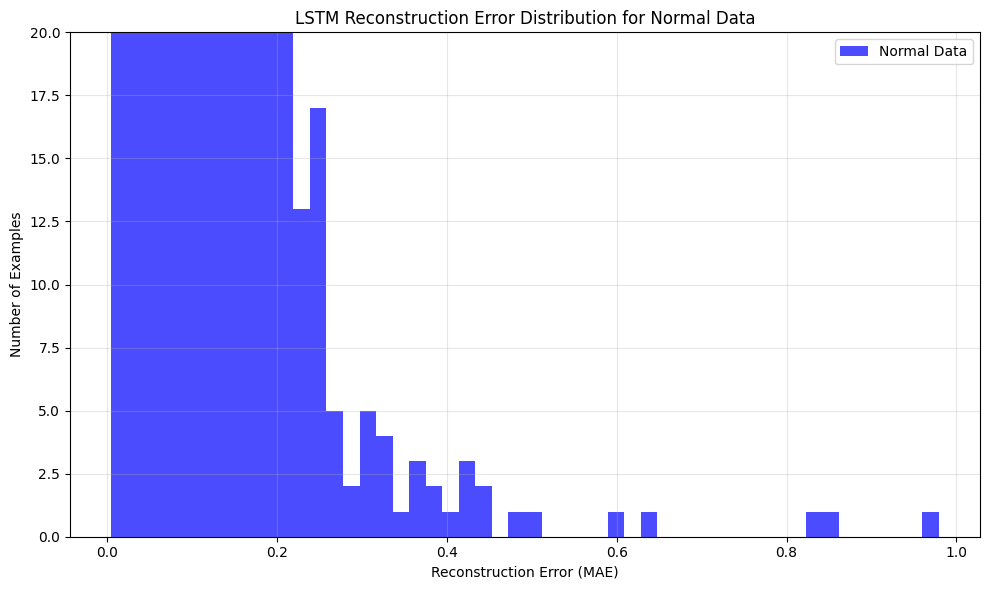

In [6]:
# Plot reconstruction error distribution for normal training data
reconstructions_normal = lstm.predict(test_data_scaled_normal)
train_loss_normal = tf.keras.losses.mae(reconstructions_normal, test_data_scaled_normal)

plt.figure(figsize=(10, 6))
plt.hist(train_loss_normal.numpy().flatten(), bins=50, color='blue', alpha=0.7, label='Normal Data')

plt.title('LSTM Reconstruction Error Distribution for Normal Data', fontsize=12)
plt.xlabel('Reconstruction Error (MAE)', fontsize=10)
plt.ylabel('Number of Examples', fontsize=10)
plt.ylim(0,20)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


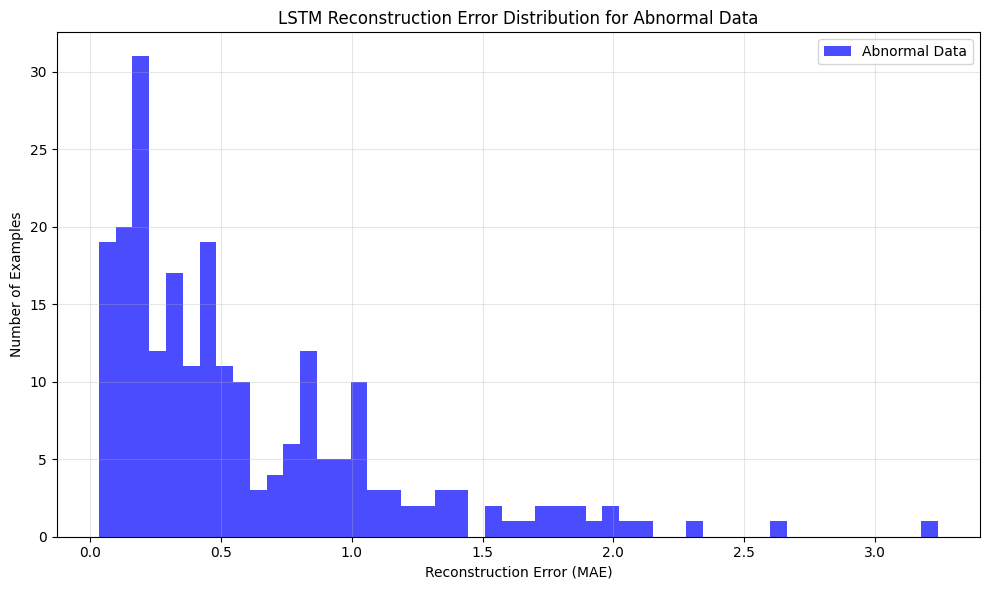

Mean reconstruction error: 0.0332
Median reconstruction error: 0.4340
Standard deviation: 0.5357


In [7]:
#Plot the reconstruction error on abnormal data from the training set
reconstructions_abnormal = lstm.predict(test_data_scaled_abnormal)
train_loss_abnormal = tf.keras.losses.mae(reconstructions_abnormal, test_data_scaled_abnormal)

plt.figure(figsize=(10, 6))
plt.hist(train_loss_abnormal.numpy().flatten(), bins=50, color='blue', alpha=0.7, label='Abnormal Data')

plt.title('LSTM Reconstruction Error Distribution for Abnormal Data', fontsize=12)
plt.xlabel('Reconstruction Error (MAE)', fontsize=10)
plt.ylabel('Number of Examples', fontsize=10)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Mean reconstruction error: {np.min(train_loss_abnormal):.4f}")
print(f"Median reconstruction error: {np.median(train_loss_abnormal):.4f}")
print(f"Standard deviation: {np.std(train_loss_abnormal):.4f}")


--- Using Low Threshold: 0.200000 ---


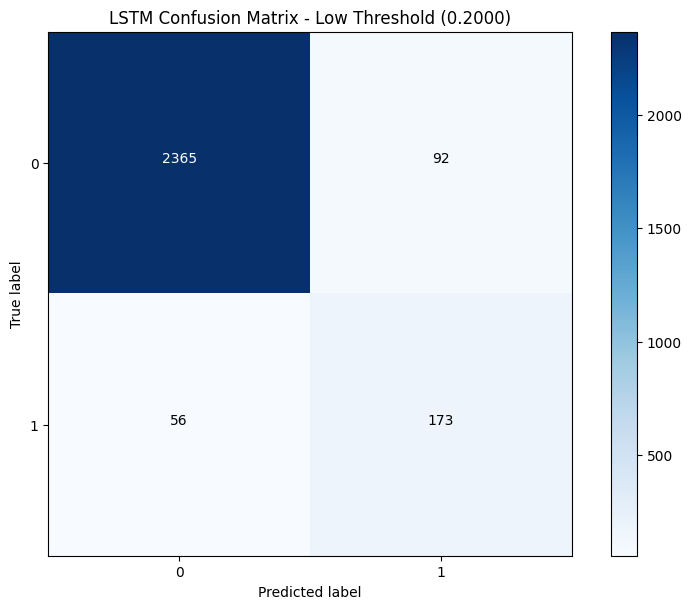


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2457
           1       0.65      0.76      0.70       229

    accuracy                           0.94      2686
   macro avg       0.81      0.86      0.84      2686
weighted avg       0.95      0.94      0.95      2686

Accuracy: 0.9449
Precision: 0.6528
Recall: 0.7555
F1 Score: 0.7004

--- Using Middle Threshold: 0.376742 ---


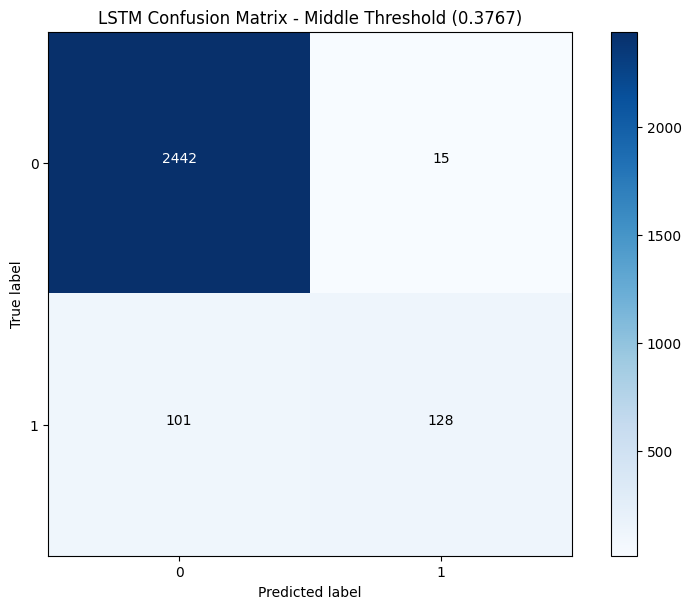


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2457
           1       0.90      0.56      0.69       229

    accuracy                           0.96      2686
   macro avg       0.93      0.78      0.83      2686
weighted avg       0.95      0.96      0.95      2686

Accuracy: 0.9568
Precision: 0.8951
Recall: 0.5590
F1 Score: 0.6882

--- Using High Threshold: 0.691475 ---


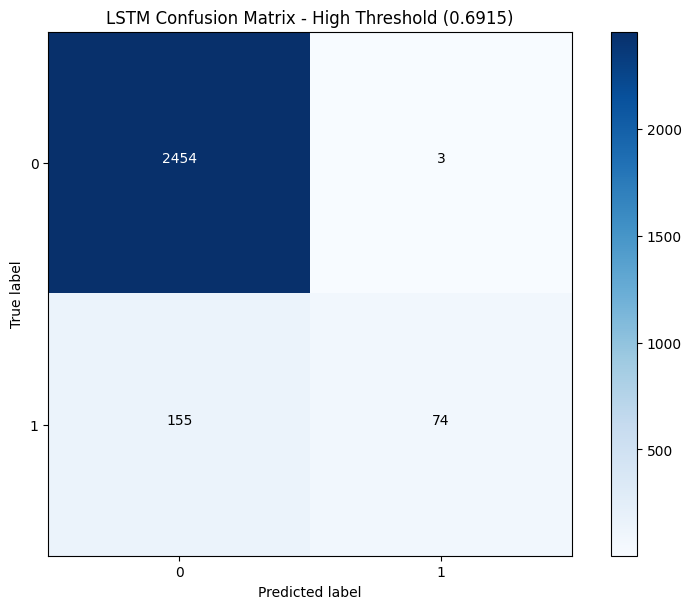


Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2457
           1       0.96      0.32      0.48       229

    accuracy                           0.94      2686
   macro avg       0.95      0.66      0.73      2686
weighted avg       0.94      0.94      0.93      2686

Accuracy: 0.9412
Precision: 0.9610
Recall: 0.3231
F1 Score: 0.4837

--- Threshold Comparison ---
Threshold       Value      Accuracy   Precision  Recall     F1 Score  
-----------------------------------------------------------------
low             0.2000     0.9449     0.6528     0.7555     0.7004    
middle          0.3767     0.9568     0.8951     0.5590     0.6882    
high            0.6915     0.9412     0.9610     0.3231     0.4837    


In [12]:
# Function to create and display confusion matrix for a given threshold
def create_confusion_matrix(threshold, threshold_name):
    print(f"\n--- Using {threshold_name}: {threshold:.6f} ---")
    
    # Prepare the true labels and predictions
    true_labels = []
    predictions = []
    
    # Normal data (label 0)
    # Flatten the MAE values since LSTM outputs have an extra dimension
    normal_predictions = (train_loss_normal.numpy().flatten() > threshold).astype(int)
    true_labels.extend([0] * len(normal_predictions))
    predictions.extend(normal_predictions)
    
    # Abnormal data (label 1)
    abnormal_predictions = (train_loss_abnormal.numpy().flatten() > threshold).astype(int)
    true_labels.extend([1] * len(abnormal_predictions))
    predictions.extend(abnormal_predictions)
    
    # Create confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'LSTM Confusion Matrix - {threshold_name} ({threshold:.4f})')
    plt.colorbar()
    
    classes = ['0', '1']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Label the plot
    thresh = conf_matrix.max() / 2
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=classes))
    
    # Calculate and display metrics
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return {
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix
    }

# Generate confusion matrices for all thresholds
results = {}

# Check which threshold keys are available in your JSON
if 'low_threshold' in loaded_thresholds:
    results['low'] = create_confusion_matrix(loaded_thresholds['low_threshold'], 'Low Threshold')
    
if 'middle_threshold' in loaded_thresholds:
    results['middle'] = create_confusion_matrix(loaded_thresholds['middle_threshold'], 'Middle Threshold')
    
if 'high_threshold' in loaded_thresholds:
    results['high'] = create_confusion_matrix(loaded_thresholds['high_threshold'], 'High Threshold')

# Compare the results
print("\n--- Threshold Comparison ---")
print(f"{'Threshold':<15} {'Value':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
print("-" * 65)
for name, result in results.items():
    print(f"{name:<15} {result['threshold']:<10.4f} {result['accuracy']:<10.4f} {result['precision']:<10.4f} {result['recall']:<10.4f} {result['f1']:<10.4f}")